In [121]:
import math
import re
from collections import Counter
import itertools
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx

import matplotlib.pyplot as plt

In [122]:
QUERY = "cat:cs.LG OR machine learning"
MAX_PAPERS = 300
BATCH = 100
PAUSE_SECONDS = 3

## Сбор данных
Используем API arXiv для загрузки публикаций по запросу *machine learning* и смежным категориям.
Загружено 258 статей, каждая содержит: идентификатор, название, авторов, аннотацию, дату публикации. Т.к.  запрос возвращал не более 100 статей, делали повторные запросы с проверкой на отсутствие дублирования id.

`getattr()` поможет безопасно обработать хоть словарь, хоть объект.                                        Используем категории: машинное обучение, искуственный интелект, статистика/ML.


In [123]:
import arxiv
from tqdm import tqdm

def fetch_arxiv_multi(queries, per_query=100):
    client = arxiv.Client()
    results = []
    seen_ids = set()   # сюда будем складывать ID статей

    for q in queries:
        search = arxiv.Search(
            query=q,
            max_results=per_query,
            sort_by=arxiv.SortCriterion.SubmittedDate
        )

        print(f"Fetching {per_query} papers for query: {q}")
        for r in tqdm(client.results(search), total=per_query):
            paper_id = getattr(r, 'entry_id', None) or getattr(r, 'id', None)
            if paper_id in seen_ids:
                continue  # пропускаем дубликат

            results.append({
                'id': paper_id,
                'title': r.title,
                'summary': r.summary,
                'published': r.published,
                'updated': r.updated,
                'authors': [a.name for a in r.authors],
                'categories': r.categories,
            })
            seen_ids.add(paper_id)

    return results


queries = [
    "cat:cs.LG",    # машинное обучение
    "cat:cs.AI",    # искусственный интеллект
    "cat:stat.ML"   # статистика / ML
]

In [124]:
raw = fetch_arxiv_multi(queries, per_query=100)
print("Fetched (без дублей):", len(raw))

Fetching 100 papers for query: cat:cs.LG


100%|██████████| 100/100 [00:00<00:00, 203.56it/s]


Fetching 100 papers for query: cat:cs.AI


100%|██████████| 100/100 [00:03<00:00, 31.78it/s]


Fetching 100 papers for query: cat:stat.ML


100%|██████████| 100/100 [00:02<00:00, 33.47it/s]

Fetched (без дублей): 258


## Подготовка данных (далее будет лемматизация, здесь - базовая нормализация)
Приводим к стандартизированному виду понижением регистра, заменой символа переноса строки на пробелы, избавлением от лишних пробелов. Как можно заметить, раньше было удобнее работать скорее как с объектом - датафрейм же работает именно со словарями.

In [125]:
def clean_text(s):
    if s is None:
        return ''
    s = s.lower()
    s = re.sub(r"\n", ' ', s)
    s = re.sub(r"[^a-z0-9\s]", ' ', s)
    s = re.sub(r"\s+", ' ', s).strip()
    return s

In [126]:
papers = []
for item in raw:
    text = (item['title'] or '') + ' ' + (item['summary'] or '')
    papers.append({
    'id': item['id'] or '',
    'title': item['title'] or '',
    'authors': item['authors'] or [],
    'summary': item['summary'] or '',
    'text': clean_text(text)
})


df = pd.DataFrame(papers)
print('Dataframe shape:', df.shape)

Dataframe shape: (258, 5)


Частично глянем на dataframe:
(колонки прям подписаны)

In [127]:
print(df.head(5))  # первые 5 строк


                                  id  \
0  http://arxiv.org/abs/2510.03224v1   
1  http://arxiv.org/abs/2510.03222v1   
2  http://arxiv.org/abs/2510.03215v1   
3  http://arxiv.org/abs/2510.03209v1   
4  http://arxiv.org/abs/2510.03207v1   

                                               title  \
0  Test-Time Defense Against Adversarial Attacks ...   
1  Low-probability Tokens Sustain Exploration in ...   
2  Cache-to-Cache: Direct Semantic Communication ...   
3  Joint Bidding on Intraday and Frequency Contai...   
4  To Distill or Decide? Understanding the Algori...   

                                             authors  \
0  [Dong Lao, Yuxiang Zhang, Haniyeh Ehsani Oskou...   
1  [Guanhua Huang, Tingqiang Xu, Mingze Wang, Qi ...   
2  [Tianyu Fu, Zihan Min, Hanling Zhang, Jichao Y...   
3   [Yiming Zhang, Wolfgang Ridinger, David Wozabal]   
4  [Yuda Song, Dhruv Rohatgi, Aarti Singh, J. And...   

                                             summary  \
0  We propose a test-time def

In [128]:
if df.shape[0] < 250:
    print(f"Warning: collected only {df.shape[0]} papers (<250). Consider increasing MAX_PAPERS or adjusting query.)")


## TF-IDF и TfidfVectorizer

**TF-IDF** — мера важности слова в документе относительно всего корпуса:

- **TF (Term Frequency)** — частота слова в документе:
$$
TF(t,d) = \frac{\text{количество вхождений терма } t \text{ в документе } d}{\text{общее число слов в документе } d}
$$

- **DF (Document Frequency)** — число документов, где встречается слово:
$$
DF(t) = |\{ d \in D : t \in d \}|
$$

- **IDF (Inverse Document Frequency)** — обратная частота документа:
$$
IDF(t,D) = \log \frac{N}{1 + DF(t)}
$$

- **TF-IDF** — произведение TF и IDF:
$$
TF\text{-}IDF(t,d,D) = TF(t,d) \times IDF(t,D)
$$

**TfidfVectorizer** (sklearn) превращает тексты в числовую матрицу TF-IDF:
- строки → документы
- столбцы → слова/термы
- значения → важность слова в документе

В нашем анализе: выбираем **top-K терминов** по TF-IDF для каждой статьи и строим граф ключевых слов и публикаций. Используем **униграммы и биграммы**, чтобы учитывать отдельные слова и двухсловные фразы, повышая точность ключевых слов.


## Продолжение нормализации (применение - через два блока)
Я выбрала лемманизацию — приведение слова к его словарной форме (лемме) с учётом части речи, например running → run, went → go. В отличие от стемминга, который просто обрезает окончания и может создавать некорректные формы (studies → studi), лемматизация сохраняет осмысленные слова. **Важно отметить, что она особенно полезна для анализа текстов и построения графов ключевых слов, так как объединяет все морфологические варианты в одну сущность**. Базовая нормализация, такая как приведение к нижнему регистру и очистка текста, применена ранее.

In [214]:
import spacy

nlp = spacy.load("en_core_web_sm")
# ДОБАВЛЕНИЕ НОРМАЛИЗАЦИИ - я выбрала лемматизацию, которая приводит все слова к их словарной форме (лемме), объединяя морфологические варианты в одну сущность.
def normalize_terms(terms):
    doc = nlp(" ".join(terms))
    return [token.lemma_ for token in doc if token.is_alpha]


In [215]:
vectorizer = TfidfVectorizer(
ngram_range=(1,2),
max_df=0.8, # слишком частые токены игнорим
min_df=2, # но хотя бы в двух документах быть должен
max_features=5000,
stop_words='english'
)


X = vectorizer.fit_transform(df['text'])
feature_names = np.array(vectorizer.get_feature_names_out())


Будем брать для каждой статьи по 8 терминов с максимальным значением из матрицы TF-IDF. \
**Применяем нормализацию**

In [216]:
TOP_K = 8


doc_terms = []
for i in range(X.shape[0]):
    row = X[i].toarray().ravel()
    top_idx = np.argsort(row)[-TOP_K:][::-1]
    top_terms = [t for t in feature_names[top_idx] if row[top_idx].sum() > 0]

    top_terms = [t for t in top_terms if row[feature_names.tolist().index(t)] > 0] if len(top_terms)>0 else []
    top_terms = normalize_terms(top_terms) #ПРИМЕНЕНИЕ НОРМАЛИЗАЦИИ
    doc_terms.append(top_terms)

Ключевые слова и их количество - для примера 15 самых частых из различных документов

In [218]:
df['keywords'] = doc_terms


all_terms = list(itertools.chain.from_iterable(df['keywords'].tolist()))
term_counts = Counter(all_terms)
print('Unique terms extracted:', len(term_counts))
print('Top 15 terms:', term_counts.most_common(15))


Unique terms extracted: 960
Top 15 terms: [('model', 25), ('diffusion', 24), ('learn', 18), ('time', 17), ('agent', 16), ('gradient', 14), ('neural', 14), ('sample', 14), ('detection', 13), ('feature', 12), ('reasoning', 11), ('evaluation', 11), ('risk', 11), ('base', 11), ('image', 10)]


Добавляем узлы (ключевые слова) и рёбра. `itertools.combinations(set(keywords), 2)` - выбираем по два уникальных слова из одной статьи. Если встретили более одно раза - кроме уже созданного ребра увеличиваем его вес.

In [162]:
G_kw = nx.Graph()
# добавляем узлы
for term in term_counts:
    G_kw.add_node(term, count=term_counts[term])


# добавляем взвешенные ребра
for keywords in df['keywords']:
    # уникальные пары
    for a, b in itertools.combinations(set(keywords), 2):
        if G_kw.has_edge(a, b):
            G_kw[a][b]['weight'] += 1
        else:
            G_kw.add_edge(a, b, weight=1)

In [154]:
print('Keyword graph: nodes=', G_kw.number_of_nodes(), 'edges=', G_kw.number_of_edges())

Keyword graph: nodes= 960 edges= 6615


In [177]:
communities = nx.community.louvain_communities(G_kw, resolution=0.9)
mod = nx.community.modularity(G_kw, communities)
print(f"# of clusters: {len(communities)}, Modularity: {mod}")

node_community = {}
for i, com in enumerate(communities):
    for node in com:
        node_community[node] = i

# of clusters: 12, Modularity: 0.6357442839499735


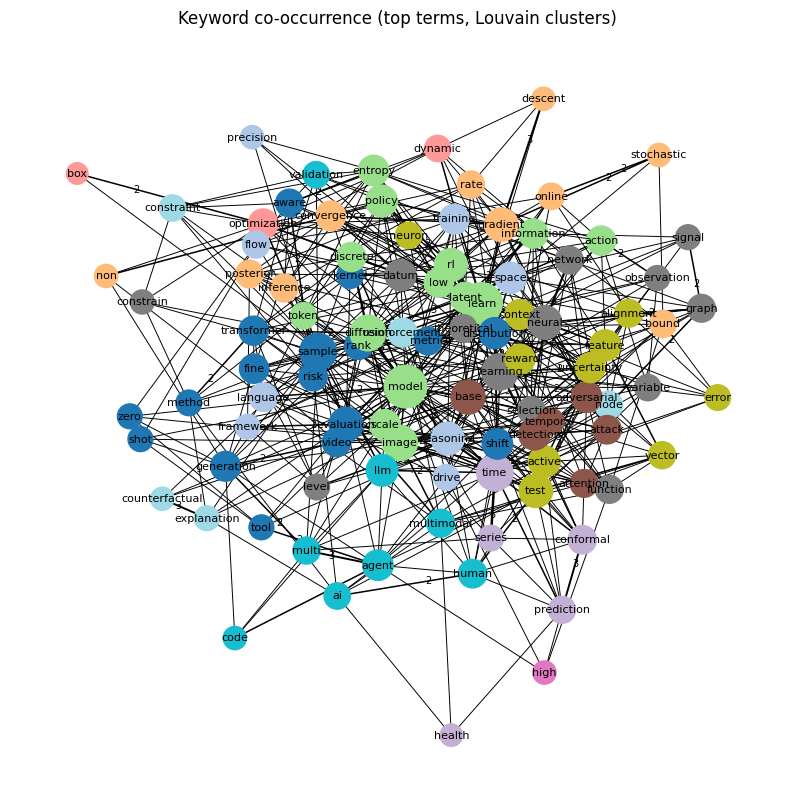

In [164]:
TOP_N = 100
most_common_nodes = [t for t, _ in term_counts.most_common(TOP_N)]
subG = G_kw.subgraph(most_common_nodes).copy()

plt.figure(figsize=(10,10))
pos = nx.spring_layout(subG, seed=42)

node_color = [node_community.get(n, 0) for n in subG.nodes()]
node_size = [200 + 20*subG.degree(n) for n in subG.nodes()]

nx.draw_networkx_nodes(subG, pos, node_size=node_size, cmap=plt.cm.tab20, node_color=node_color)
nx.draw_networkx_labels(subG, pos, font_size=8)

# Рёбра по весу
edges = subG.edges(data=True)
weights = [d['weight'] for (_,_,d) in edges]

edge_labels = {
    (u, v): d['weight']
    for u, v, d in subG.edges(data=True)
    if d['weight'] > 1
}

nx.draw_networkx_edge_labels(
    subG,
    pos,
    edge_labels=edge_labels,
    font_size=7,
    label_pos=0.7,
    rotate=False
)

nx.draw_networkx_edges(subG, pos, width=[max(0.2, math.log(w+1)) for w in weights])
plt.title('Keyword co-occurrence (top terms, Louvain clusters)')
plt.axis('off')
plt.show()


## Для более точной интерпретации (будет после текущего блока) посмотрим на полученные кластеры.

In [168]:
from collections import defaultdict

communities = defaultdict(list)
for node, com_id in node_community.items():
    communities[com_id].append(node)
communities = list(communities.values())

for i, com in enumerate(communities):
    print(f"Cluster {i} ({len(com)} nodes): {com}")


Cluster 0 (113 nodes): ['ambiguity', 'upper', 'reproducible', 'tuning', 'intra', 'literature', 'comparative', 'humidity', 'prompt', 'recording', 'randomize', 'sample', 'culturally', 'strategy', 'transformer', 'ppo', 'rlaif', 'risk', 'draw', 'miss', 'shot', 'partial', 'random', 'audio', 'imputation', 'effective', 'synchronize', 'trace', 'reduce', 'group', 'curse', 'synthesis', 'lens', 'connection', 'video', 'hypernetwork', 'kernel', 'fine', 'lora', 'allocation', 'structure', 'tts', 'unconditional', 'run', 'statistical', 'horizon', 'algorithm', 'augmented', 'verifier', 'correlation', 'ridge', 'classical', 'oracle', 'tune', 'zero', 'robust', 'hyper', 'inductive', 'singular', 'centric', 'ucb', 'sampling', 'foundation', 'thing', 'informed', 'method', 'sit', 'distribution', 'process', 'evaluation', 'shift', 'sacrifice', 'rank', 'speaker', 'survey', 'noise', 'unsupervised', 'target', 'alternate', 'pre', 'nest', 'metric', 'regression', 'categorical', 'train', 'explainable', 'augment', 'site', 

## Интерпретация кластеров Louvain
Для более удобной визуализации я выбрала 100 наиболее частых слов. В целом в графе (ранее указано в подсчётах) получилось 12 кластеров (при том в графе 960 узлов и 6615 рёбер). Каждый объединяет слова, часто встречающиеся вместе в публикациях, что отражает общие направления исследований.
Были выделены следующие кластеры:

- **Cluster 0 (113 слов)** — включает термины, связанные с методологией и оптимизацией моделей (*tuning, regression, bias, robustness*). Описывает настройку параметров и повышение устойчивости алгоритмов.
- **Cluster 1 (123 слова)** — объединяет понятия оценивания и интерпретации (*precision, reasoning, explainability, framework*). Отражает направление оценки качества и объяснимости моделей.
- **Cluster 2 (73 слова)** — охватывает математические и вероятностные основы обучения (*relu, descent, posterior, inference*), связанные с байесовскими и стохастическими методами.
- **Cluster 3 (110 слов)** — характеризует генеративные и диффузионные подходы (*diffusion, autoregressive, latent, image*), связанные с моделированием распределений и генерацией данных.
- **Cluster 4 (62 слова)** — фокусируется на приватности и каузальности (*causal, privacy, law, dataset*), отражая прикладные и этические аспекты ИИ.
- **Cluster 5 (56 слов)** — объединяет темы временных рядов и прогнозирования (*forecasting, time, planning, spatiotemporal*), включая медицинские и инженерные приложения.
- **Cluster 6 (37 слов)** — описывает методы обнаружения аномалий и устойчивости (*anomaly, robustness, adversarial, detection*).
- **Cluster 7 (44 слова)** — связан с обработкой изображений и визуальными признаками (*pixel, coordinate, resolution, mapping*).
- **Cluster 8 (103 слова)** — охватывает распределённое и прикладное обучение (*federated, contrastive, fairness, neural*), включая вопросы безопасности и честности моделей.
- **Cluster 9 (76 слов)** — отражает когнитивные и нейронные модели (*neuron, contextual, biological, uncertainty*), вдохновлённые биологическими процессами.
- **Cluster 10 (88 слов)** — описывает архитектурные и инженерные применения (*integration, automation, workflow, safety*), связанные с внедрением ИИ-систем.
- **Cluster 11 (75 слов)** — объединяет понятия объяснимости и оптимизации (*xai, explanation, convex, heuristic*), относящиеся к алгоритмам обучения с подкреплением и логическим моделям.

Что можно отметить: \
Применение алгоритма Louvain позволило выявить устойчивые тематические сообщества в графе ключевых слов, построенном на основе корпуса научных публикаций.
Предварительная лемматизация текстов обеспечила морфологическое объединение различных форм слов, что способствовало более точному определению смысловых связей между терминами и, как следствие, — повышению качества кластеризации.
Каждое сообщество отражает отдельное направление исследований в области искусственного интеллекта: от фундаментальных алгоритмических принципов и оптимизационных методов до прикладных, когнитивных и этических аспектов.
Полученная структура графа характеризуется достаточно высокой модулярностью (
Q≈0.636), что отражает сильную внутрикластерную связанность и умеренные межкластерные взаимодействия



In [190]:
centralities = {}
centralities['degree'] = nx.degree_centrality(G_kw)
centralities['betweenness'] = nx.betweenness_centrality(G_kw, weight='weight')
centralities['eigenvector'] = nx.eigenvector_centrality_numpy(G_kw, weight='weight')
centralities['closeness'] = nx.closeness_centrality(G_kw)

## Слова с наибольшими значениями центральностей
`Degree centrality показывает наиболее «связанные» термины, активно участвующие в ко-употреблении:
model (13.03%), learn (11.37%), sample (8.65%), time (8.55%), diffusion (7.72%), image (7.19%), learning (7.19%), reasoning (6.67%), datum (6.67%), base (6.57%). Эти слова формируют ядро терминологии.`

`Betweenness centrality выявляет «мосты» между кластерами:
model (7.19%), learn (5.63%), sample (5.12%), time (3.91%), image (3.17%), learning (3.11%), datum (3.06%), gradient (2.65%), diffusion (2.52%), reasoning (2.44%), играющие ключевую роль в распространении смысловых связей между направлениями исследований.`

`Eigenvector centrality показывает термины, находящиеся в «влиятельных» регионах графа:
model (32.76%), diffusion (26.50%), learn (20.90%), time (17.52%), image (14.96%), reasoning (14.94%), base (14.63%), sample (12.23%), discrete (12.00%), distribution (11.06%), тесно связанные с фундаментальными концепциями.`

`Closeness centrality отражает термины, которые обеспечивают быструю семантическую связность и находятся в центре сети:
model (47.24%), learn (46.80%), time (45.49%), sample (44.34%), diffusion (44.03%), base (43.87%), image (43.75%), evaluation (43.45%), reasoning (43.22%), neural (43.00%).`

`Совокупно эти показатели демонстрируют, что термины model, learn, time, sample, diffusion consistently занимают ключевые позиции по всем метрикам, выступая одновременно как ядро, связующие элементы, влиятельные узлы и центральные точки сети. Это подтверждает их фундаментальное значение для формирования тематических направлений и интеграции смысловых связей в корпусе публикаций.`

In [191]:
for name, cent in centralities.items():
    top = sorted(cent.items(), key=lambda t: t[1], reverse=True)[:10]
    print(f"Top 10 by {name}:")
    for node, value in top:
        print(f"{node}: {value:.4f}")
    print("\n")


Top 10 by degree:
model: 0.1303
learn: 0.1137
sample: 0.0865
time: 0.0855
diffusion: 0.0772
image: 0.0719
learning: 0.0719
reasoning: 0.0667
datum: 0.0667
base: 0.0657


Top 10 by betweenness:
model: 0.0719
learn: 0.0563
sample: 0.0512
time: 0.0391
image: 0.0317
learning: 0.0311
datum: 0.0306
gradient: 0.0265
diffusion: 0.0252
reasoning: 0.0244


Top 10 by eigenvector:
model: 0.3276
diffusion: 0.2650
learn: 0.2090
time: 0.1752
image: 0.1496
reasoning: 0.1494
base: 0.1463
sample: 0.1223
discrete: 0.1200
distribution: 0.1106


Top 10 by closeness:
model: 0.4724
learn: 0.4680
time: 0.4549
sample: 0.4434
diffusion: 0.4403
base: 0.4387
image: 0.4375
evaluation: 0.4345
reasoning: 0.4322
neural: 0.4300




## Граф публикаций (поиск описан ниже, результаты выводятся более явно и корректно)

In [193]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

P = nx.Graph()

for idx, row in df.iterrows():
    short_title = " ".join(row['title'].split()[:5])
    P.add_node(idx, title=row['title'], short_title=short_title)

term_to_docs = defaultdict(list)
for idx, kws in enumerate(df['keywords']):
    for kw in set(kws):
        term_to_docs[kw].append(idx)

for kw, docs in term_to_docs.items():
    for a, b in itertools.combinations(docs, 2):
        if P.has_edge(a, b):
            P[a][b]['weight'] += 1
        else:
            P.add_edge(a, b, weight=1)

print('Publication graph nodes=', P.number_of_nodes(), 'edges=', P.number_of_edges())


Publication graph nodes= 258 edges= 2594


Заметно по соотношению рёбер и узлов, что статьи тематически пересекаются. \
Визуализация:

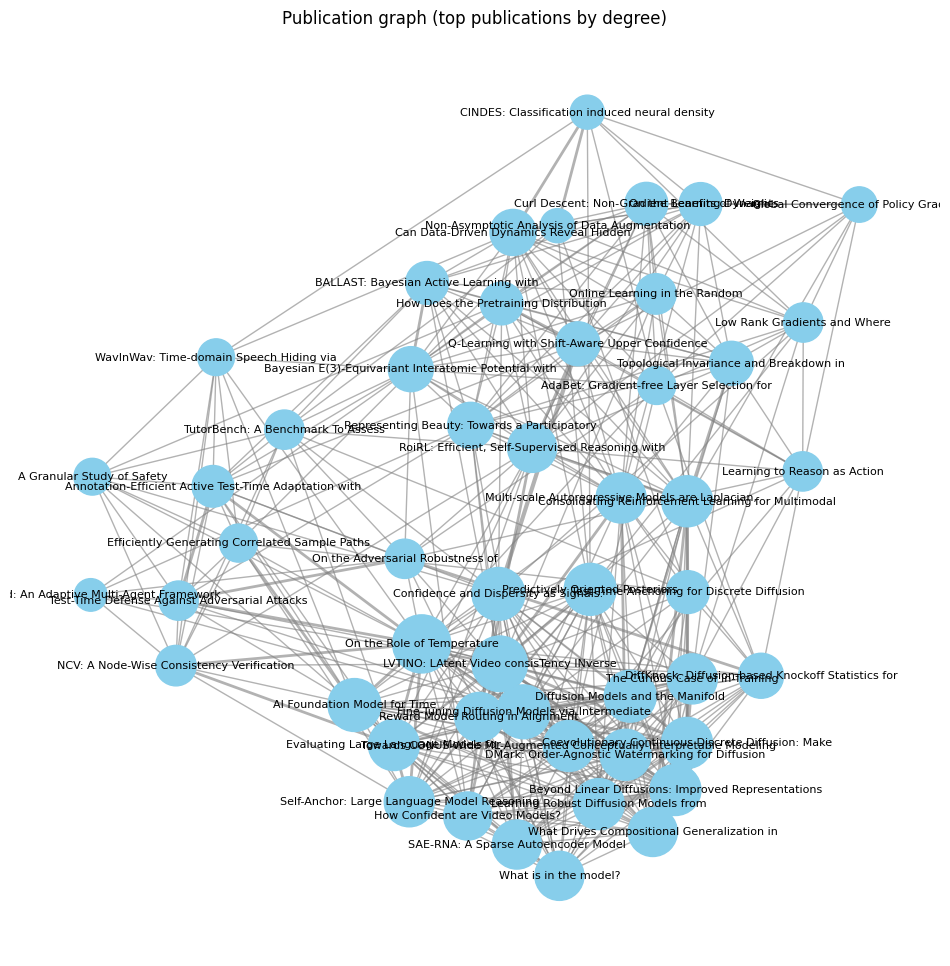

In [194]:
TOP_N = 50
top_nodes = sorted(P.degree, key=lambda x: x[1], reverse=True)[:TOP_N]
subP = P.subgraph([n for n, _ in top_nodes])

plt.figure(figsize=(12,12))
pos = nx.spring_layout(subP, k=0.5, seed=42)

node_size = [200 + 50*subP.degree(n) for n in subP.nodes()]
edge_weights = [max(0.2, w['weight']) for u, v, w in subP.edges(data=True)]

nx.draw_networkx_nodes(subP, pos, node_size=node_size, node_color='skyblue')
nx.draw_networkx_edges(subP, pos, width=edge_weights, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(
    subP, pos,
    labels={n: subP.nodes[n]['short_title'] for n in subP.nodes()},
    font_size=8
)

plt.title("Publication graph (top publications by degree)")
plt.axis('off')
plt.show()


## Поиск похожих публикаций (ВЕС РЕБРА, как мера сходства - кол-во общих слов относительно двух взятых сравниваемых документов)

- Каждая публикация представлена как **узел** в графе `P`.
- Между двумя публикациями создаём **ребро**, если они имеют хотя бы одно общее ключевое слово.
- Атрибут ребра `weight` = число **общих ключевых слов** между публикациями.
- Для заданной публикации `pub_idx`:
  1. Берём всех её соседей в графе (публикации с общими словами).
  2. Сортируем по `weight` (число общих слов) в порядке убывания.
  3. Выбираем топ-k публикаций с наибольшим весом — это и есть **самые похожие публикации**.

**Вывод:** чем выше `weight`, тем больше общих ключевых слов между статьями и тем сильнее их схожесть.


In [200]:
def get_top_similar(pub_idx, top_k=10):
    neighbors = P[pub_idx]
    sorted_neighbors = sorted(neighbors.items(), key=lambda x: x[1]['weight'], reverse=True)
    return [(n, data['weight'], P.nodes[n]['title']) for n, data in sorted_neighbors[:top_k]]

In [204]:
from IPython.display import display, Markdown

def display_top_similar(pub_indices, top_k=10):
    for pub_idx in pub_indices:
        pub_title = P.nodes[pub_idx]['title']
        top_similar = get_top_similar(pub_idx, top_k=top_k)

        display(Markdown(f"### Топ {top_k} похожих публикаций для публикации {pub_idx}: **{pub_title}** (ID={pub_idx})"))

        md_table = "| ID публикации | Публикация | Сходство (число общих ключевых слов) |\n"
        md_table += "|---------------|------------|--------------------------------------|\n"
        for n, weight, title in top_similar:
            short_title = title if len(title) <= 60 else title[:57] + "..."
            md_table += f"| {n} | {short_title} | {weight} |\n"
        display(Markdown(md_table))

# Проверим наиболее схожие публикации с публикациями с индексами 0, 1, 2
display_top_similar([0, 1, 2], top_k=10)


### Топ 10 похожих публикаций для публикации 0: **Test-Time Defense Against Adversarial Attacks via Stochastic Resonance of Latent Ensembles** (ID=0)

| ID публикации | Публикация | Сходство (число общих ключевых слов) |
|---------------|------------|--------------------------------------|
| 226 | On the Adversarial Robustness of Learning-based Conformal... | 2 |
| 97 | On the Role of Temperature Sampling in Test-Time Scaling | 2 |
| 255 | Annotation-Efficient Active Test-Time Adaptation with Con... | 2 |
| 84 | A Statistical Method for Attack-Agnostic Adversarial Atta... | 2 |
| 119 | Untargeted Jailbreak Attack | 2 |
| 19 | The Computational Complexity of Almost Stable Clustering ... | 1 |
| 182 | Flatness-Aware Stochastic Gradient Langevin Dynamics | 1 |
| 22 | Real Time Headway Predictions in Urban Rail Systems and I... | 1 |
| 45 | RAxSS: Retrieval-Augmented Sparse Sampling for Explainabl... | 1 |
| 49 | WavInWav: Time-domain Speech Hiding via Invertible Neural... | 1 |


### Топ 10 похожих публикаций для публикации 1: **Low-probability Tokens Sustain Exploration in Reinforcement Learning with Verifiable Reward** (ID=1)

| ID публикации | Публикация | Сходство (число общих ключевых слов) |
|---------------|------------|--------------------------------------|
| 90 | To Compress or Not? Pushing the Frontier of Lossless GenA... | 2 |
| 126 | Global Convergence of Policy Gradient for Entropy Regular... | 2 |
| 141 | TravelBench : Exploring LLM Performance in Low-Resource D... | 1 |
| 190 | Lower Bounds on Adversarial Robustness for Multiclass Cla... | 1 |
| 212 | Low Rank Gradients and Where to Find Them | 1 |
| 129 | Constraint Satisfaction Approaches to Wordle: Novel Heuri... | 1 |
| 205 | On the Identifiability of Latent Action Policies | 1 |
| 218 | Approximation of differential entropy in Bayesian optimal... | 1 |
| 245 | EVODiff: Entropy-aware Variance Optimized Diffusion Infer... | 1 |
| 4 | To Distill or Decide? Understanding the Algorithmic Trade... | 1 |


### Топ 10 похожих публикаций для публикации 2: **Cache-to-Cache: Direct Semantic Communication Between Large Language Models** (ID=2)

| ID публикации | Публикация | Сходство (число общих ключевых слов) |
|---------------|------------|--------------------------------------|
| 73 | TokenFlow: Responsive LLM Text Streaming Serving under Re... | 3 |
| 1 | Low-probability Tokens Sustain Exploration in Reinforceme... | 1 |
| 52 | DMark: Order-Agnostic Watermarking for Diffusion Large La... | 1 |
| 67 | Align Your Query: Representation Alignment for Multimodal... | 1 |
| 117 | When and Where do Events Switch in Multi-Event Video Gene... | 1 |
| 115 | A Study of Neural Polar Decoders for Communication | 1 |
| 219 | Error Feedback for Muon and Friends | 1 |
| 82 | Time-To-Inconsistency: A Survival Analysis of Large Langu... | 1 |
| 113 | HAVIR: HierArchical Vision to Image Reconstruction using ... | 1 |
| 161 | Knowledge-Graph Based RAG System Evaluation Framework | 1 |


## ИТОГО:
**Публикация 0**: Test-Time Defense Against Adversarial Attacks via Stochastic Resonance of Latent Ensembles (ID=0) \
Наибольшее сходство (2 общих ключевых слова) имеют статьи по тестовым адаптациям и защите от атак. Остальные публикации пересекаются по одному ключевому слову — менее прямое тематическое совпадение.

**Публикация 1**: Low-probability Tokens Sustain Exploration in Reinforcement Learning with Verifiable Reward (ID=1) \
Статьи с 2 общими ключевыми словами связаны с методами RL и градиентными подходами. Остальные публикации пересекаются по одному термину, показывая слабую тематическую близость.

**Публикация 2**: Cache-to-Cache: Direct Semantic Communication Between Large Language Models (ID=2) \
Наибольшее сходство (3 общих ключевых слова) имеет публикация TokenFlow: Responsive LLM Text Streaming Serving under Re... Остальные статьи имеют по одному общему ключевому слову, что указывает на более слабое тематическое пересечение.


## Возможные рекомендации и расширения моей версии
Для графа ключевых слов: \
Можно фильтровать части речи (оставлять только существительные и прилагательные) через spaCy, чтобы убрать шум. Использовать RAKE, YAKE или KeyBERT для более качественной экстракции фраз вместо простого разделения по словам. Для семантической близости слов можно применять TF-IDF или нейросетевые эмбединги (Word2Vec, BERT), что позволяет учитывать контекст и синонимы.

Для графа публикаций: \
Вес ребра отражает число общих ключевых слов, но можно улучшить схожесть через TF-IDF и косинусную близость текста публикаций. Эмбединги нейросетей (BERT, SciBERT, Sentence-BERT) помогают находить публикации, близкие по смыслу, даже если слова не совпадают дословно. Для крупных графов ускорение возможно через pyspark, graph-tool или FAISS; визуализацию — через Gephi или Cytoscape.

